In [36]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
hate_data = pd.read_csv("hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('badword.csv',encoding='CP949') # 일베 문장

## 문장 전처리

In [38]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label']==1]

In [39]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label']==1]

In [40]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label']==1]

In [41]:
# 데이터 개수
print("hate_data : %d" % len(hate_data))
print("genderbias_data : %d" % len(genderbias_data))
print("ilbe_data : %d" % len(ilbe_data))

hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044


## 라벨링 및 합치기

In [42]:
# 렌덤하게 문장 추출 후 라벨링 거치는 함수
def random_labeling(data, classified_data, label_num, str_num):  # label_num : 라벨링 시킬 값, str_num 추출할 문장 개수
    random_data = classified_data.sample(n=str_num) # str_num 개의 행(문장) 랜덤 추출
    random_data.loc[random_data.label == 1, 'label'] = label_num # label_num으로 값 변경
    data = data.append(random_data)  # data 에 랜덤 추출된 데이터 추가
    return data

In [43]:
data_declaration = {
    'comment' : ["str_Declaration"],
    'label':[-1]
}


data = pd.DataFrame(data_declaration)
data

,comment,label
0,str_Declaration,-1


In [44]:
# 문장 개수를 모두 2000 개로 지정 각 
# 라벨은 혐오:0, 여성비하: 1, 일베: 2로 지정됨
data = random_labeling(data, hate_data, 0, 2000)
data = random_labeling(data, genderbias_data, 1, 1200)
data = random_labeling(data, ilbe_data, 2, 2000)

In [45]:
# 첫번째 행 제거
data = data.drop(0)

In [46]:
# 랜덤하게 섞기 
data = data.sample(frac=1).reset_index(drop=True)

In [47]:
data[:10]

,comment,label
0,토론에서 지면 현피를 뜨는 지능 수준 잘 알았다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,2
1,요즘 신종사기가 이거임틀딱들이 40대 아줌매미 에게결혼하면 10억대 아파트 명의준다...,2
2,아이들도 어른이 저도 재밌게 봤어요....,0
3,어렸을때보고 지금다시봐도 재밌어요~ 캐스팅 자체가 고퀄리티,0
4,현아는 남친이 있어도 그 입술이 남친의 것이 아니라 팬들의 것임. 누구 맘대로 시술...,1
5,사진땜시 기분 잣같아져서 ㅁㅈㅎ,2
6,와 씨발 중국이냐. 진짜 죠센징들은 날이 갈수록 퇴화하노.,2
7,응 근데 ㅅㅂ 고졸 무스펙인데 따도 할수있으려나 모르겠다 다시 노가다나 해야하나,2
8,완전 재미었어요,0
9,백상에서도 인정 받은 드라마 나저씨를 왜 페미들은 인정안함?ㅋㅋㅋ,1


## 중복 및 null 처리

In [48]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [49]:
detect_overlap(data)

In [50]:
# null 값 확인
data.isnull().values.any()

False

## 토큰화

In [51]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [52]:
x_data = data['comment']
y_data = data['label']

In [53]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)

## 희귀단어 확인

In [54]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [55]:
# 희귀 단어 확인
detect_rareword(tokenizer, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 23664
단어 집합(vocabulary)에서 희귀 단어의 비율: 83.4561805678011
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 48.867320598864225


## 훈련 데이터, 테스트 데이터 분리

In [56]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

In [57]:
# 최대 길이 계산
X_data = sequences
maxlen = max_length(X_data)

In [58]:
Y_data = np.array(y_data)

In [59]:
Y_data

array([2, 2, 0, ..., 2, 1, 0], dtype=int64)

## 문장 길이 분포 확인

문장 최대 길이 : 194
문장 평균 길이 : 9.323258


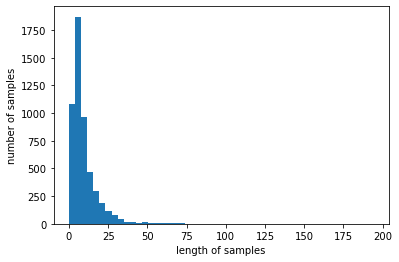

In [60]:
print('문장 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터, 학습 데이터 분할

In [61]:
# 훈련 및 학습 데이터 개수 비율 지정
numtrain, numtest = num_dataset(0.8, X_data)

In [62]:
# 가장 긴 길이로 맞추기
X_data = pad_sequences(X_data, maxlen = maxlen)

# 학습 과정

In [63]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pandas as pd
import tensorflow.keras.metrics 
from keras import backend as K
from sklearn.model_selection import KFold

In [64]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))

## 모델 학습

In [ ]:
# size = 1000000
# model = Sequential()
# model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
# model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
# model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
# num_of_class = 3 #클래스는 우선 4개로 분류함
# model.add(Dense(num_of_class, activation='linear'))
# ##model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
# model.summary()

size = 1000000

kfold = KFold(n_splits= 2, shuffle = True)

for train, test in kfold.split(X_data, Y_data):
    model = Sequential()
    model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    num_of_class = 3 #클래스는 우선 4개로 분류함
    model.add(Dense(num_of_class, activation='linear'))
    ##model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["accuracy",f1,precision, recall])
    es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
    check_point = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)
    
    hist = model.fit(X_data, y_data, batch_size = 16, epochs=5, callbacks=[es, check_point])

Epoch 1/5
325/325 [==============================] - 422s 1s/step - loss: 3.7203 - accuracy: 0.3233 - f1: 0.0543 - precision: 2334180.4998 - recall: 0.0274
Epoch 2/5
325/325 [==============================] - 426s 1s/step - loss: 1.2567 - accuracy: 0.3578 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/5
325/325 [==============================] - 463s 1s/step - loss: 1.1471 - accuracy: 0.3444 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/5
325/325 [==============================] - 695s 2s/step - loss: 1.1143 - accuracy: 0.3512 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/5
325/325 [==============================] - 714s 2s/step - loss: 1.1193 - accuracy: 0.3621 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1/5
302/325 [==========================>...] - ETA: 50s - loss: 2.4180 - accuracy: 0.3444 - f1: 0.0125 - precision: 614551.3231 - recall: 0.0062

## Training

In [90]:
X_result = model.predict(test, batch_size = 16)
X_result

ValueError: in user code:

    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\layers\convolutional.py:248 call
        outputs = self._convolution_op(inputs, self.kernel)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:1013 convolution_v2
        return convolution_internal(
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:1143 convolution_internal
        return op(
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py:605 new_func
        return func(*args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py:605 new_func
        return func(*args, **kwargs)
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:1885 conv1d
        result = gen_nn_ops.conv2d(
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:968 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3528 _create_op_internal
        ret = Operation(
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 3 from 1 for '{{node sequential_3/conv1d_3/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_3/conv1d_3/conv1d/ExpandDims, sequential_3/conv1d_3/conv1d/ExpandDims_1)' with input shapes: [?,1,1,64], [1,3,64,64].


# OpenMax

In [85]:
class_result = []
for a,b,c in X_result:
    numbers = [a,b,c]
    class_result.append(numbers.index(max(numbers)))
    
tf_result = (y_data == class_result)

for_open_max_0 = [] 
for_open_max_1 = []
for_open_max_2 = []

for i in range(len(class_result)):
    if(tf_result[i] == True):
        if(class_result[i] == 0):
            for_open_max_0.append(X_result[i])
        if(class_result[i] == 1):
            for_open_max_1.append(X_result[i])
        if(class_result[i] == 2):
            for_open_max_2.append(X_result[i])

KeyError: 678

## 평균 Logit Vector 계산

In [ ]:
def average_vector(for_open_max, class_result):
    a1=0
    a2=0
    a3=0
    for i in for_open_max:
        a1 += i[0]
        a2 += i[1]
        a3 += i[2]
    length = len(class_result)
    average = [a1/length, a2/length, a3/length]
    return average

average_0 = average_vector(for_open_max_0, class_result) #평균 Logit Vector - Class 0
average_1 = average_vector(for_open_max_1, class_result) #평균 Logit Vector - Class 1
average_2 = average_vector(for_open_max_2, class_result) #평균 Logit Vector - Class 2

## Distance 계산

In [ ]:
def distance(for_open_max, average):
    dist = []
    for i in for_open_max:
        m = i - average
        distance = (m[0]**2) + (m[1]**2) + (m[2]**2)
        dist.append(distance)
    return dist

dist0 = distance(for_open_max_0, average_0)
dist1 = distance(for_open_max_1, average_1)
dist2 = distance(for_open_max_2, average_2)

dist0.sort(reverse =True)
dist1.sort(reverse =True)
dist2.sort(reverse =True)

In [ ]:
# Distance 상위 20개 추출
maxdist0=[]
maxdist1=[]
maxdist2=[]
for i in range(0,20):
    maxdist0.append(dist0[i])
for j in range(0,20):
    maxdist1.append(dist1[j])
for k in range(0,20):
    maxdist2.append(dist2[k])

In [ ]:
#극단 분포 도구
import scipy.stats as s
import matplotlib.pyplot as plt

#def weib(x,n,a):
#    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)
def weib(x,n,a):
    return 1-np.exp[-(x / n)**a]

In [ ]:
# 0 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc, scale) = s.exponweib.fit_loc_scale(maxdist0, 1, 1)
print(loc, scale)

plt.plot(maxdist0, s.exponweib.cdf(maxdist0, *s.exponweib.fit(maxdist0, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist0, bins=np.linspace(0, 16, len(maxdist0)), alpha=0.5);
plt.show()

In [ ]:
# 1 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc, scale) = s.exponweib.fit_loc_scale(maxdist1, 1, 1)
print(loc, scale)

plt.plot(maxdist1, s.exponweib.cdf(maxdist1, *s.exponweib.fit(maxdist1, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist1, bins=np.linspace(0, 16, len(maxdist1)), alpha=0.5);
plt.show()

In [ ]:
## 2 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc, scale) = s.exponweib.fit_loc_scale(maxdist2, 1, 1)
print(loc, scale)

plt.plot(maxdist2, s.exponweib.cdf(maxdist2, *s.exponweib.fit(maxdist2, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist2, bins=np.linspace(0, 16, len(maxdist2)), alpha=0.5);
plt.show()

In [ ]:
# def calculCDF(dist):
#     CDF = []
#     for i in dist:
#         CDF.append(s.exponweib.cdf(i, *s.exponweib.fit(i, 1, 1, scale=2, loc=0)))
#     return CDF
# CDF0 = calculCDF(dist0)
# CDF1 = calculCDF(dist1)
# CDF2 = calculCDF(dist2)

# updated_logit = []
# i = 0
# for a,b,c in X_result:
#     logit0 = a-(a*CDF0[i])
#     logit1 = b-(b*CDF1[i])
#     logit2 = c-(c*CDF2[i])
#     unkn_logit = CDF0[i]*a + CDF1[i]*b + CDF2[i]*c    # unknown class의 logit vector
#     updated_logit.append([unkn_logit, logit0, logit1, logit2])
#     i += 1
# # update 된 logit veoctor로 softmax layer 통과
# print(updated_logit)

## Softmax Layer 통과

In [ ]:
model2 = Sequential()
model2.add(Dense(num_of_class + 1, activation = 'softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics= ["accuracy"])

In [ ]:
model2.fit(X_result, y_test, batch_size = 16)

In [ ]:
model2.predict(X_result, batch_size = 16)

## 결과 확인

In [ ]:
#모델 학습 과정 표시

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
result = pd.DataFrame(model.predict(X_test, batch_size=16),columns=['0', '1', '2'])
result["Test Label"] = y_test
result["Classification Result"] = class_result
result["Final Result"] = (y_test == class_result)

result.to_csv("test_result.csv")

In [ ]:
print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

## 모델 저장

In [ ]:
##모델을 .json 파일 형식으로 save하여 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("model_weight.h5")
model.save('full_model.h5')

In [ ]:
##모델 조정이 끝나면, Model을 사용 하여 OpenMax에 필요한 자료를 선정하여 OpenMax로 구현할 예정입니다.